#Stress-Testing of Convolutional Neural Networks on CIFAR-100

Group Members :-
1. Gautam Kumar Kushwaha (M25CSA037)
2. Aryan Baranwal (M25CSE035)
3. Parth Pitrubhakta (M25CSE022)

#STEP 1 — Install required libraries for CNN training and analysis

In [ ]:
!pip install torch torchvision matplotlib tqdm grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=0de25b2801945483ff461b228425fea725141564bd642921bc8de98e4dd953f2
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


# STEP 2: Verify Grad-CAM Installation

In [ ]:
# Import Grad-CAM to ensure explainability library is available
from pytorch_grad_cam import GradCAM
# Confirmation message
print("Grad-CAM installed!")


Grad-CAM installed!


# STEP 3: Import Required Libraries

In [ ]:
# PyTorch core libraries (model building and training)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Torchvision for CIFAR-100 dataset and ResNet-18 architecture
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.utils import save_image

# Numerical computation and reproducibility
import numpy as np
import random

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# File handling and logging
import csv
import os

# Progress bar for training loops
from tqdm import tqdm

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Grad-CAM for explainability analysis
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


# STEP 4: Experiment Configuration

In [ ]:
# Fixed random seed for reproducibility
SEED = 42

# Training Parameters
EPOCHS = 40                 # Maximum number of training epochs
BATCH = 128                # Batch size
LR = 0.01                  # Initial learning rate
PATIENCE = 6               # Early stopping patience
WARMUP_EPOCHS = 5          # Warmup epochs for learning rate scheduler

# Regularization
LABEL_SMOOTH = 0.1         # Label smoothing factor
MAX_GRAD_NORM = 5.0       # Gradient clipping threshold
WEIGHT_DECAY = 5e-4       # L2 regularization strength

# Dataset Settings
VAL_RATIO = 0.2           # Fraction of training data used for validation
NUM_VIS_SAMPLES = 15      # Number of images to visualize
FAILURE_CONF_THRESH = 0.90  # Confidence threshold for saving failure cases

# Paths
CHECKPOINT_DIR = "checkpoints"   # Saved models
PLOT_DIR = "plots"               # Training curves and figures
FAILURE_DIR = "failures"         # Misclassified samples
GRADCAM_DIR = "gradcam"          # Grad-CAM visualizations
LOG_DIR = "logs"                 # CSV training logs
HISTORY_CSV = os.path.join(LOG_DIR, "history.csv")

# Create all required directories
for d in [CHECKPOINT_DIR, PLOT_DIR, FAILURE_DIR, GRADCAM_DIR, LOG_DIR]:
    os.makedirs(d, exist_ok=True)


#STEP 5: Set Random Seeds & Select Device

In [ ]:
# Set random seeds to ensure reproducible experiments
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# STEP 6: Data Preprocessing and Dataset Loading

In [ ]:
# CIFAR-100 channel-wise mean and standard deviation (for normalization)
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

# Training transformations (includes data augmentation)
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test/Validation transformations (no augmentation)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-100 full training dataset
full_train = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_tf
)

# Load CIFAR-100 test dataset
test_dataset = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_tf
)

100%|██████████| 169M/169M [00:05<00:00, 31.8MB/s]


# STEP 6.1: Verify Dataset Sizes

In [ ]:
print(len(full_train))
print(len(test_dataset))

50000
10000


# STEP 6.2: Verify Number of Classes

In [ ]:
print(len(full_train.classes))

100


# STEP 6.3: Display Sample Class Names

In [ ]:
classes = full_train.classes
print("First 5 classes:")
for i, class_name in enumerate(classes[:5]):
    print(f"{i+1}. {class_name}")

First 5 classes:
1. apple
2. aquarium_fish
3. baby
4. bear
5. beaver


# STEP 7: Train–Validation Split

In [ ]:
# Split the full training set into training and validation subsets
train_size = int(len(full_train) * (1 - VAL_RATIO))
val_size = len(full_train) - train_size

train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Display dataset sizes
print(f"Train: {len(train_dataset)}  Val: {len(val_dataset)}  Test: {len(test_dataset)}")


Train: 40000  Val: 10000  Test: 10000


# STEP 8: Visualize Dataset Split

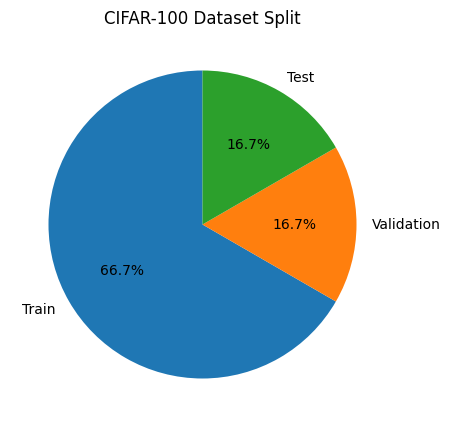

In [ ]:
# Prepare sizes of Train / Validation / Test sets
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]

# Plot pie chart to show dataset distribution
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=["Train","Validation","Test"],
        autopct="%1.1f%%", startangle=90)

plt.title("CIFAR-100 Dataset Split")
plt.show()

# STEP 9: Create DataLoaders

In [ ]:
# DataLoaders for efficient batch processing
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# Store CIFAR-100 class names
classes = full_train.classes

# STEP 10: Visualize CIFAR-100 Sample Images

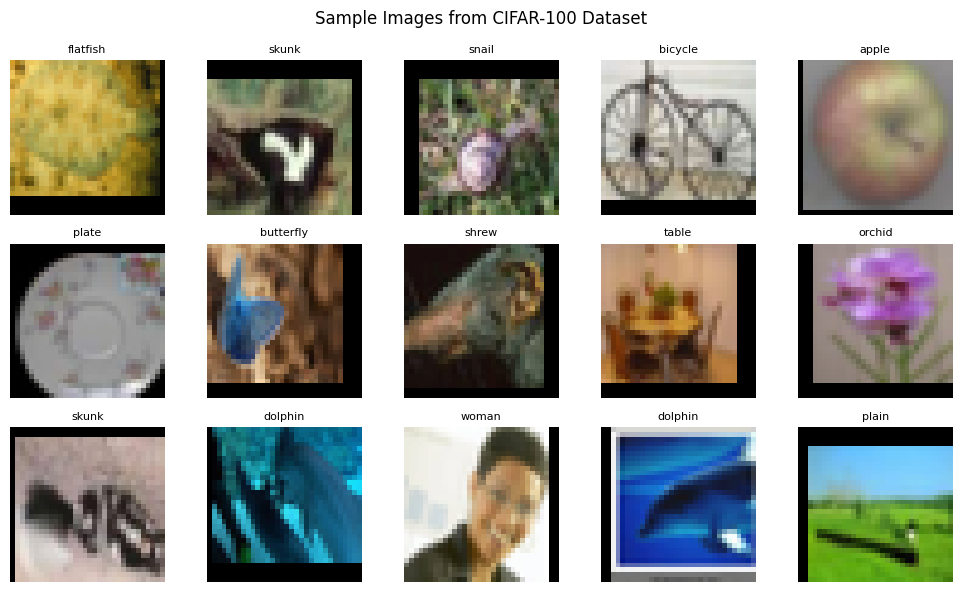

In [ ]:
# Use CIFAR-100 class names from full training dataset
def show_cifar_samples(dataset, num_images=15):
    plt.figure(figsize=(10,6))

    for i in range(num_images):
        img, label = dataset[i]

        # Undo normalization for display
        img = img.permute(1,2,0).numpy()
        img = img * np.array(std) + np.array(mean)
        img = np.clip(img, 0, 1)

        plt.subplot(3,5,i+1)
        plt.imshow(img)
        plt.title(classes[label], fontsize=8)
        plt.axis("off")

    plt.suptitle("Sample Images from CIFAR-100 Dataset")
    plt.tight_layout()
    plt.show()


# Call function
show_cifar_samples(train_dataset)


# STEP 10.1: Dataset Visualization (Train / Val / Test)

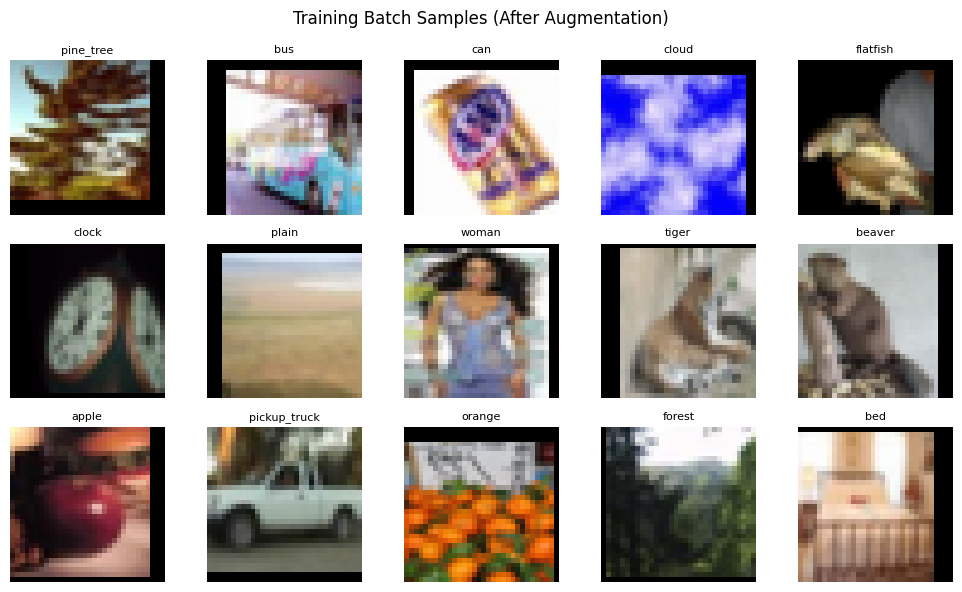

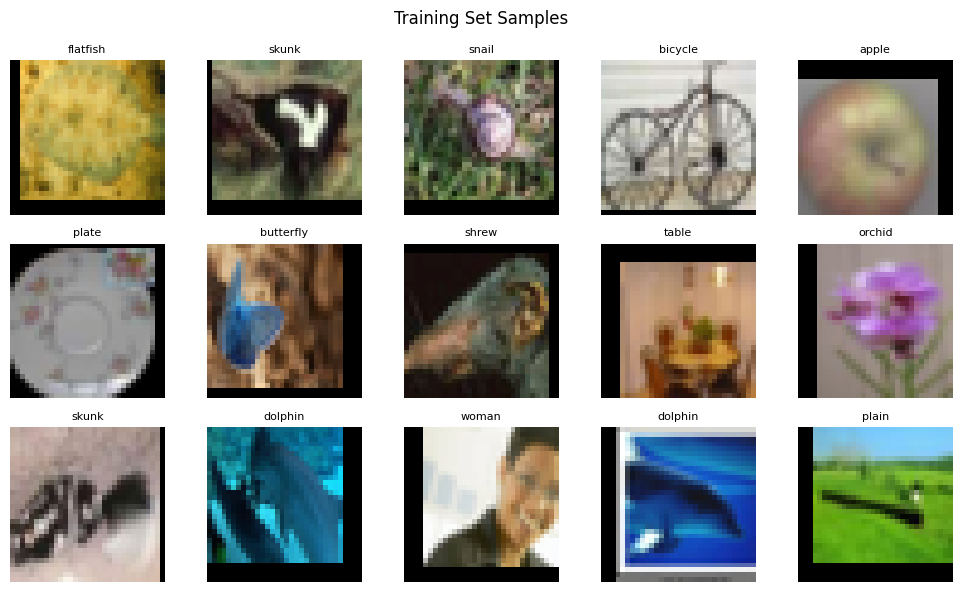

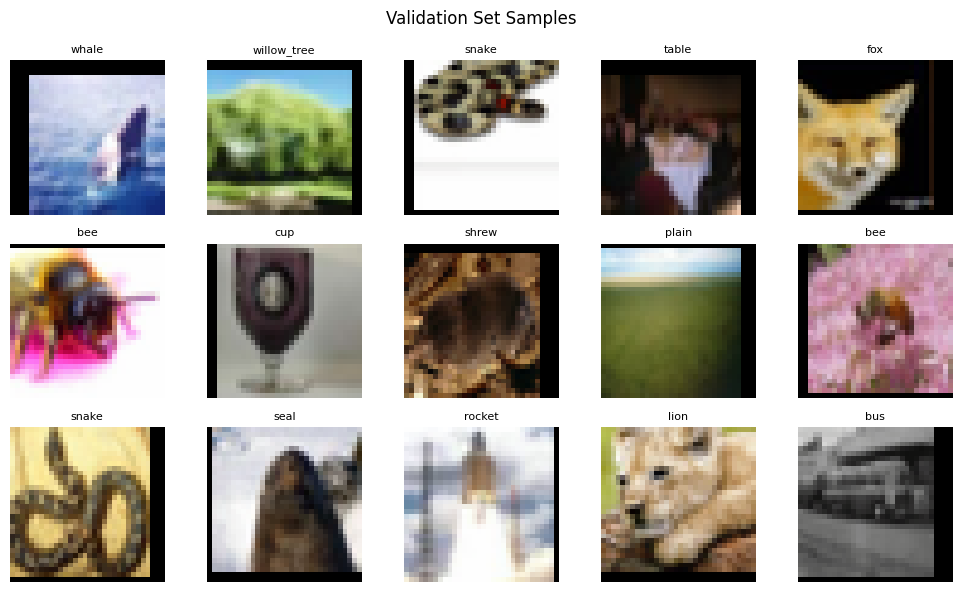

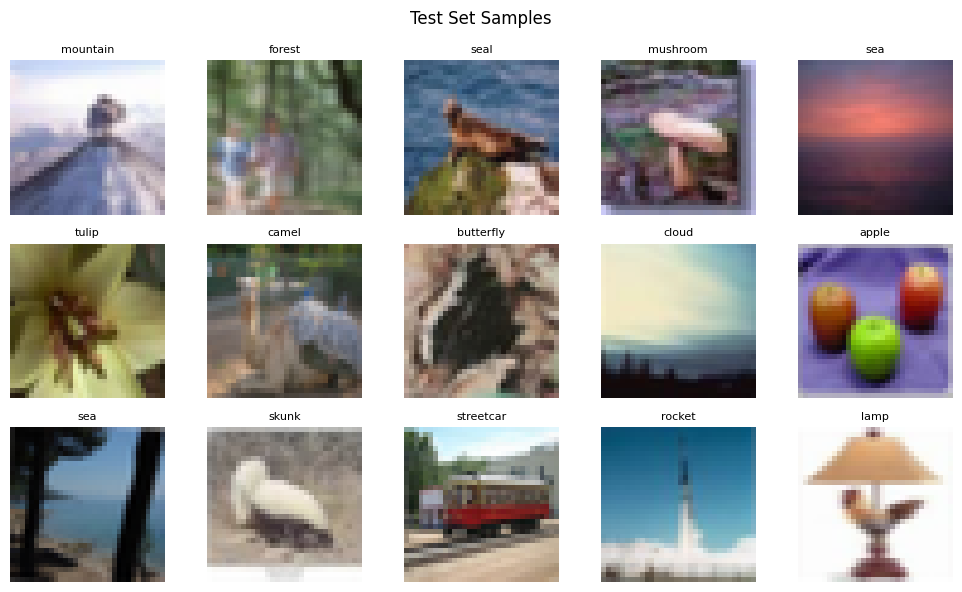

In [ ]:
classes = full_train.classes

# TRAINING BATCH
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,6))
for i in range(NUM_VIS_SAMPLES):
    img = images[i].permute(1,2,0).numpy()
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img,0,1)

    plt.subplot(3,5,i+1)
    plt.imshow(img)
    plt.title(classes[labels[i]], fontsize=8)
    plt.axis("off")

plt.suptitle("Training Batch Samples (After Augmentation)")
plt.tight_layout()
plt.show()

# GENERIC SAMPLE FUNCTION
def show_samples(dataset, title):
    plt.figure(figsize=(10,6))

    for i in range(NUM_VIS_SAMPLES):
        img,label = dataset[i]
        img = img.permute(1,2,0).numpy()
        img = img * np.array(std) + np.array(mean)
        img = np.clip(img,0,1)

        plt.subplot(3,5,i+1)
        plt.imshow(img)
        plt.title(classes[label], fontsize=8)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# VISUALIZE ALL SPLITS
show_samples(train_dataset, "Training Set Samples")
show_samples(val_dataset, "Validation Set Samples")
show_samples(test_dataset, "Test Set Samples")


# STEP 11: Model Definition (ResNet-18)

In [ ]:
# Initialize ResNet-18 without pretrained weights
model = resnet18(pretrained=False)

# Modify first convolution layer for CIFAR-100 (32x32 images)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Remove max-pooling layer to preserve spatial resolution
model.maxpool = nn.Identity()

# Replace final fully connected layer for 100 CIFAR classes
model.fc = nn.Linear(512, 100)

# Move model to selected device (GPU/CPU)
model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# STEP 12: Loss, Optimizer, Scheduler, and AMP

In [ ]:
# Cross-entropy loss with label smoothing to reduce over-confidence
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

# Stochastic Gradient Descent optimizer with momentum and Nesterov acceleration
optimizer = optim.SGD(
    model.parameters(),
    lr=LR,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY,
    nesterov=True
)

# Cosine learning rate schedule with warmup
def lr_lambda(epoch):
    warmup = WARMUP_EPOCHS
    if epoch < warmup:
        return epoch / warmup
    return 0.5 * (1 + np.cos(np.pi * (epoch - warmup) / (EPOCHS - warmup)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Automatic Mixed Precision (AMP) for faster training and lower memory usage
scaler = torch.amp.GradScaler("cuda")


# STEP 13: Training Loop

In [ ]:
def train_epoch():
    model.train()
    loss_sum = 0
    correct = total = 0

    Device = device
    for x, y in tqdm(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        # Modern AMP
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(x)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()

        # Gradient clipping to stabilize training
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item()
        _, preds = outputs.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()


    return loss_sum / len(train_loader), 100 * correct / total

# STEP 14: Validation and Failure Case Discovery

In [ ]:
def eval_epoch(epoch):
    model.eval()
    loss_sum = 0
    correct = total = 0
    failures = 0

    Device = device
    with torch.no_grad():
        for x, y in val_loader:   # VALIDATION loader (not test!)
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)

            probs = torch.softmax(outputs, 1)
            conf, preds = probs.max(1)

            # Save high-confidence failures
            for i in range(len(y)):
                if preds[i] != y[i] and conf[i] > FAILURE_CONF_THRESH and failures < 10:
                    torchvision.utils.save_image(
                        x[i],
                        f"{FAILURE_DIR}/e{epoch}_c{conf[i]:.2f}.png",
                        normalize=True
                    )
                    failures += 1

            loss_sum += loss.item()
            total += y.size(0)
            correct += preds.eq(y).sum().item()

    return loss_sum / len(val_loader), 100 * correct / total


# STEP 15: Main Training Loop

In [ ]:
best = 0
early_stop = 0

train_acc, val_acc = [], []
train_loss, val_loss = [], []

# Define DEVICE for use in train_epoch and eval_epoch functions
DEVICE = device

with open(HISTORY_CSV, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch","train_loss","val_loss","train_acc","val_acc"])

    for epoch in range(EPOCHS):

        tl, ta = train_epoch()
        vl, va = eval_epoch(epoch)

        scheduler.step()

        train_loss.append(tl)
        val_loss.append(vl)
        train_acc.append(ta)
        val_acc.append(va)

        writer.writerow([epoch+1, tl, vl, ta, va])

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] | "
            f"Train Loss: {tl:.4f} | "
            f"Val Loss: {vl:.4f} | "
            f"Val Acc: {va:.2f}%"
        )

        # Save best model
        if va > best:
            best = va
            torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/best.pth")
            early_stop = 0
            print("✔ Saved best model")
        else:
            early_stop += 1

        # Early stopping
        if early_stop == PATIENCE:
            print("⏹ Early stopping triggered")
            break


100%|██████████| 313/313 [00:25<00:00, 12.29it/s]


Epoch [1/40] | Train Loss: 4.7284 | Val Loss: 4.7377 | Val Acc: 0.98%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.86it/s]


Epoch [2/40] | Train Loss: 4.3336 | Val Loss: 4.0906 | Val Acc: 9.95%
✔ Saved best model


100%|██████████| 313/313 [00:21<00:00, 14.40it/s]


Epoch [3/40] | Train Loss: 3.9185 | Val Loss: 3.7666 | Val Acc: 15.71%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.10it/s]


Epoch [4/40] | Train Loss: 3.6525 | Val Loss: 3.5534 | Val Acc: 20.48%
✔ Saved best model


100%|██████████| 313/313 [00:21<00:00, 14.31it/s]


Epoch [5/40] | Train Loss: 3.3956 | Val Loss: 3.3212 | Val Acc: 25.24%
✔ Saved best model


100%|██████████| 313/313 [00:21<00:00, 14.37it/s]


Epoch [6/40] | Train Loss: 3.1521 | Val Loss: 3.1203 | Val Acc: 30.44%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch [7/40] | Train Loss: 2.9117 | Val Loss: 2.9771 | Val Acc: 34.20%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.21it/s]


Epoch [8/40] | Train Loss: 2.7263 | Val Loss: 2.8413 | Val Acc: 37.67%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.62it/s]


Epoch [9/40] | Train Loss: 2.5738 | Val Loss: 2.7044 | Val Acc: 40.65%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


Epoch [10/40] | Train Loss: 2.4391 | Val Loss: 2.5792 | Val Acc: 44.11%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.56it/s]


Epoch [11/40] | Train Loss: 2.3290 | Val Loss: 2.5189 | Val Acc: 46.56%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.55it/s]


Epoch [12/40] | Train Loss: 2.2273 | Val Loss: 2.5497 | Val Acc: 46.70%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch [13/40] | Train Loss: 2.1441 | Val Loss: 2.4120 | Val Acc: 49.88%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.57it/s]


Epoch [14/40] | Train Loss: 2.0611 | Val Loss: 2.3370 | Val Acc: 51.76%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.92it/s]


Epoch [15/40] | Train Loss: 1.9882 | Val Loss: 2.2943 | Val Acc: 52.81%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.13it/s]


Epoch [16/40] | Train Loss: 1.9229 | Val Loss: 2.2722 | Val Acc: 53.29%
✔ Saved best model


100%|██████████| 313/313 [00:21<00:00, 14.29it/s]


Epoch [17/40] | Train Loss: 1.8595 | Val Loss: 2.2003 | Val Acc: 55.92%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch [18/40] | Train Loss: 1.7950 | Val Loss: 2.1928 | Val Acc: 56.05%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.91it/s]


Epoch [19/40] | Train Loss: 1.7404 | Val Loss: 2.1602 | Val Acc: 56.87%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.76it/s]


Epoch [20/40] | Train Loss: 1.6869 | Val Loss: 2.1401 | Val Acc: 58.42%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.61it/s]


Epoch [21/40] | Train Loss: 1.6368 | Val Loss: 2.1143 | Val Acc: 58.68%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


Epoch [22/40] | Train Loss: 1.5840 | Val Loss: 2.0871 | Val Acc: 59.72%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch [23/40] | Train Loss: 1.5349 | Val Loss: 2.1174 | Val Acc: 59.21%


100%|██████████| 313/313 [00:23<00:00, 13.40it/s]


Epoch [24/40] | Train Loss: 1.4884 | Val Loss: 2.0917 | Val Acc: 59.96%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.54it/s]


Epoch [25/40] | Train Loss: 1.4473 | Val Loss: 2.0429 | Val Acc: 61.63%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.67it/s]


Epoch [26/40] | Train Loss: 1.4050 | Val Loss: 2.0287 | Val Acc: 61.77%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.49it/s]


Epoch [27/40] | Train Loss: 1.3638 | Val Loss: 1.9950 | Val Acc: 62.25%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.41it/s]


Epoch [28/40] | Train Loss: 1.3243 | Val Loss: 2.0066 | Val Acc: 62.57%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.87it/s]


Epoch [29/40] | Train Loss: 1.2923 | Val Loss: 1.9791 | Val Acc: 63.40%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.17it/s]


Epoch [30/40] | Train Loss: 1.2617 | Val Loss: 1.9741 | Val Acc: 63.30%


100%|██████████| 313/313 [00:22<00:00, 14.22it/s]


Epoch [31/40] | Train Loss: 1.2308 | Val Loss: 1.9605 | Val Acc: 63.59%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.19it/s]


Epoch [32/40] | Train Loss: 1.2087 | Val Loss: 1.9513 | Val Acc: 64.40%
✔ Saved best model


100%|██████████| 313/313 [00:30<00:00, 10.18it/s]


Epoch [33/40] | Train Loss: 1.1841 | Val Loss: 1.9431 | Val Acc: 64.49%
✔ Saved best model


100%|██████████| 313/313 [00:23<00:00, 13.52it/s]


Epoch [34/40] | Train Loss: 1.1716 | Val Loss: 1.9528 | Val Acc: 64.31%


100%|██████████| 313/313 [00:22<00:00, 13.83it/s]


Epoch [35/40] | Train Loss: 1.1578 | Val Loss: 1.9416 | Val Acc: 64.59%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 14.07it/s]


Epoch [36/40] | Train Loss: 1.1444 | Val Loss: 1.9410 | Val Acc: 64.72%
✔ Saved best model


100%|██████████| 313/313 [00:22<00:00, 13.89it/s]


Epoch [37/40] | Train Loss: 1.1350 | Val Loss: 1.9362 | Val Acc: 64.64%


100%|██████████| 313/313 [00:23<00:00, 13.27it/s]


Epoch [38/40] | Train Loss: 1.1309 | Val Loss: 1.9335 | Val Acc: 64.34%


100%|██████████| 313/313 [00:23<00:00, 13.38it/s]


Epoch [39/40] | Train Loss: 1.1248 | Val Loss: 1.9412 | Val Acc: 64.49%


100%|██████████| 313/313 [00:23<00:00, 13.31it/s]


Epoch [40/40] | Train Loss: 1.1239 | Val Loss: 1.9247 | Val Acc: 64.96%
✔ Saved best model


# STEP 16: Final Test Evaluation

In [ ]:
print("\nRunning final evaluation on TEST set...")

# Load best-performing model (based on validation accuracy)
model.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/best.pth"))
model.eval()

test_preds = []
test_labels = []

# Disable gradients during testing
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        outputs = model(x)

        # Predicted class
        preds = torch.argmax(outputs, 1)

        # Store predictions and true labels
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y.cpu().numpy())

# Compute evaluation metrics
test_acc  = accuracy_score(test_labels, test_preds)
test_prec = precision_score(test_labels, test_preds, average="macro")
test_rec  = recall_score(test_labels, test_preds, average="macro")
test_f1   = f1_score(test_labels, test_preds, average="macro")

print("\nTEST METRICS")
print("Accuracy :", test_acc)
print("Precision:", test_prec)
print("Recall   :", test_rec)
print("F1-score :", test_f1)



Running final evaluation on TEST set...

TEST METRICS
Accuracy : 0.6596
Precision: 0.6611421566245614
Recall   : 0.6596
F1-score : 0.6588375557211567


# STEP 17: Plot Training and Validation Curves

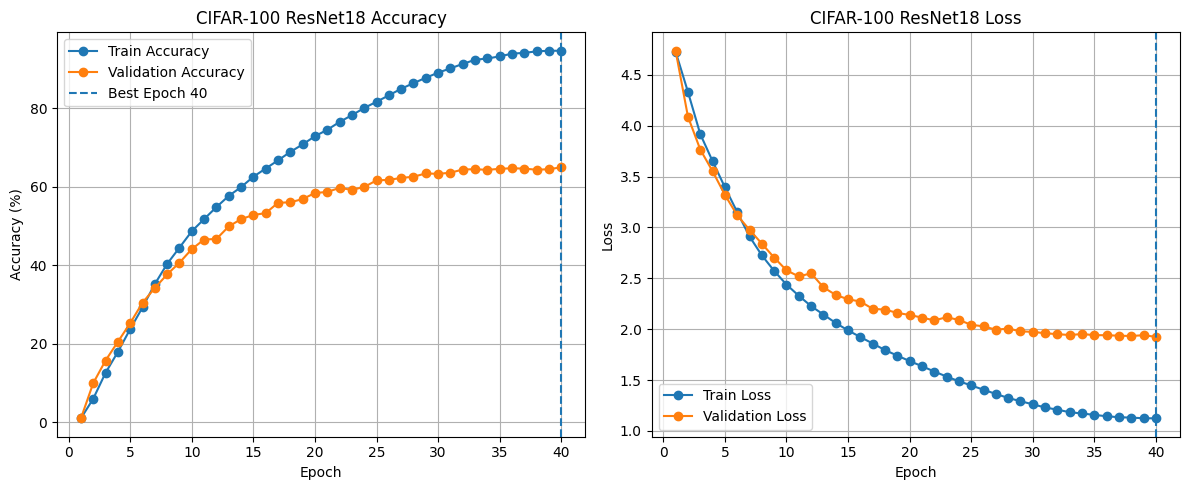

Best Validation Accuracy: 64.96% at epoch 40


In [ ]:
epochs = range(1, len(train_acc) + 1)

best_epoch = val_acc.index(max(val_acc)) + 1

plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(epochs, train_acc, marker='o', label="Train Accuracy")
plt.plot(epochs, val_acc, marker='o', label="Validation Accuracy")
plt.axvline(best_epoch, linestyle="--", label=f"Best Epoch {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CIFAR-100 ResNet18 Accuracy")
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, marker='o', label="Train Loss")
plt.plot(epochs, val_loss, marker='o', label="Validation Loss")
plt.axvline(best_epoch, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-100 ResNet18 Loss")
plt.grid(True)
plt.legend()

# Save and display plots
plt.tight_layout()
plt.savefig("plots/training_curves.png", dpi=300)
plt.show()

print(f"Best Validation Accuracy: {max(val_acc):.2f}% at epoch {best_epoch}")


# STEP 18: Grad-CAM Explainability on Test Failures

In [ ]:
from torchvision.utils import save_image

print("\nRunning Grad-CAM on test failures...")

model.load_state_dict(torch.load(f"{CHECKPOINT_DIR}/best.pth"))
model.eval()

cam = GradCAM(model=model, target_layers=[model.layer4[-1]])

MAX_CAM_SAMPLES = 10
saved = 0

# Store failure candidates to process them outside the main no_grad block
failure_candidates = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        probs = torch.softmax(outputs, 1)
        conf, preds = probs.max(1)

        for i in range(len(y)):
            if preds[i] != y[i] and conf[i] > FAILURE_CONF_THRESH:
                failure_candidates.append({
                    'image': x[i].cpu(),
                    'true_label': y[i].item(),
                    'predicted_label': preds[i].item(),
                    'confidence': conf[i].item()
                })
                if len(failure_candidates) >= MAX_CAM_SAMPLES:
                    break
        if len(failure_candidates) >= MAX_CAM_SAMPLES:
            break

print(f"Processing Grad-CAM for {len(failure_candidates)} identified failures...")
for idx, failure_data in enumerate(failure_candidates):
    img = failure_data['image']
    predicted_label = failure_data['predicted_label']
    confidence = failure_data['confidence']

    # Save original image
    save_image(
        img,
        f"{FAILURE_DIR}/fail_{idx}_conf_{confidence:.2f}.png",
        normalize=True
    )

    # Prepare RGB image for CAM overlay
    rgb = img.permute(1,2,0).numpy()
    rgb = rgb * np.array(std) + np.array(mean)
    rgb = np.clip(rgb, 0, 1)

    # Grad-CAM needs gradients, so enable them specifically for this part
    with torch.enable_grad():
        grad_cam_input = img.unsqueeze(0).to(DEVICE).clone().requires_grad_(True)
        targets = [ClassifierOutputTarget(predicted_label)]
        grayscale_cam = cam(input_tensor=grad_cam_input,
                            targets=targets)[0]

    cam_image = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)
    plt.imsave(f"{GRADCAM_DIR}/cam_{idx}_conf_{confidence:.2f}.png", cam_image)
    print(f"Saved CAM {idx+1}")

print("Grad-CAM visualizations saved.")



Running Grad-CAM on test failures...
Processing Grad-CAM for 10 identified failures...
Saved CAM 1
Saved CAM 2
Saved CAM 3
Saved CAM 4
Saved CAM 5
Saved CAM 6
Saved CAM 7
Saved CAM 8
Saved CAM 9
Saved CAM 10
Grad-CAM visualizations saved.


# Step 19: DISPLAY 3 FAILURE CASES

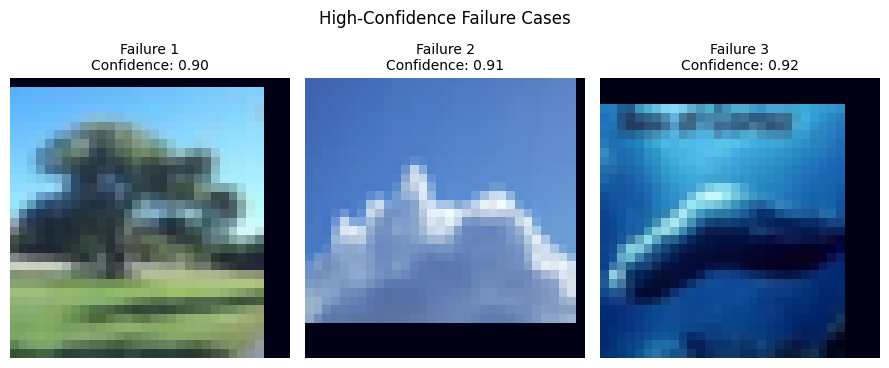

In [ ]:
from PIL import Image
import glob

failure_imgs = sorted(glob.glob(f"{FAILURE_DIR}/*.png"))[:3]

plt.figure(figsize=(9,4))

for i, path in enumerate(failure_imgs):

    img = Image.open(path)

    conf = path.split("_c")[-1].replace(".png","")

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")

    plt.title(f"Failure {i+1}\nConfidence: {conf}", fontsize=10)

plt.suptitle("High-Confidence Failure Cases")
plt.tight_layout()
plt.show()


# Step 20: DISPLAY GRAD-CAM OVERLAYS

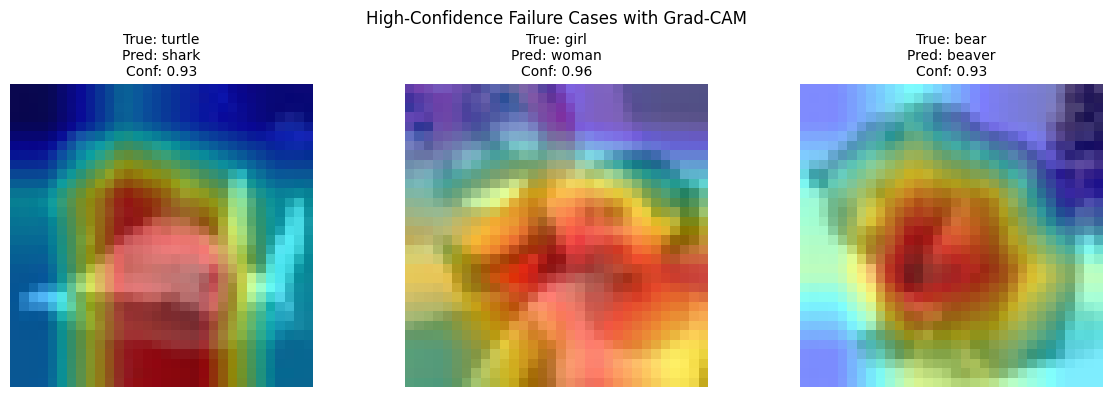

In [ ]:
plt.figure(figsize=(12,4))

for i, f in enumerate(failure_candidates[:3]):

    img = f["image"]
    true_lbl = classes[f["true_label"]]
    pred_lbl = classes[f["predicted_label"]]
    conf = f["confidence"]

    rgb = img.permute(1,2,0).numpy()
    rgb = rgb * np.array(std) + np.array(mean)
    rgb = np.clip(rgb,0,1)

    with torch.enable_grad():
        cam_input = img.unsqueeze(0).to(device).requires_grad_(True)
        targets = [ClassifierOutputTarget(f["predicted_label"])]
        grayscale = cam(cam_input, targets)[0]

    cam_img = show_cam_on_image(rgb, grayscale, use_rgb=True)

    plt.subplot(1,3,i+1)
    plt.imshow(cam_img)
    plt.axis("off")

    plt.title(
        f"True: {true_lbl}\nPred: {pred_lbl}\nConf: {conf:.2f}",
        fontsize=10
    )

plt.suptitle("High-Confidence Failure Cases with Grad-CAM")
plt.tight_layout()
plt.show()


# STEP 21: Visualize Final Test Metrics (Bar Plot)

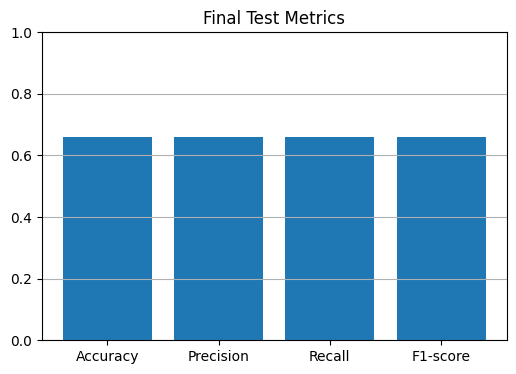

In [ ]:
# Create bar plot for Accuracy, Precision, Recall, and F1-score
import pandas as pd

# Create a DataFrame for summary metrics
summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value": [test_acc, test_prec, test_rec, test_f1]
})

plt.figure(figsize=(6,4))
plt.bar(summary_df["Metric"], summary_df["Value"])
plt.title("Final Test Metrics")
plt.ylim(0,1)
plt.grid(axis="y")
plt.savefig("plots/metrics_bar.png", dpi=300)
plt.show()

# STEP 22: Confusion Matrix Analysis

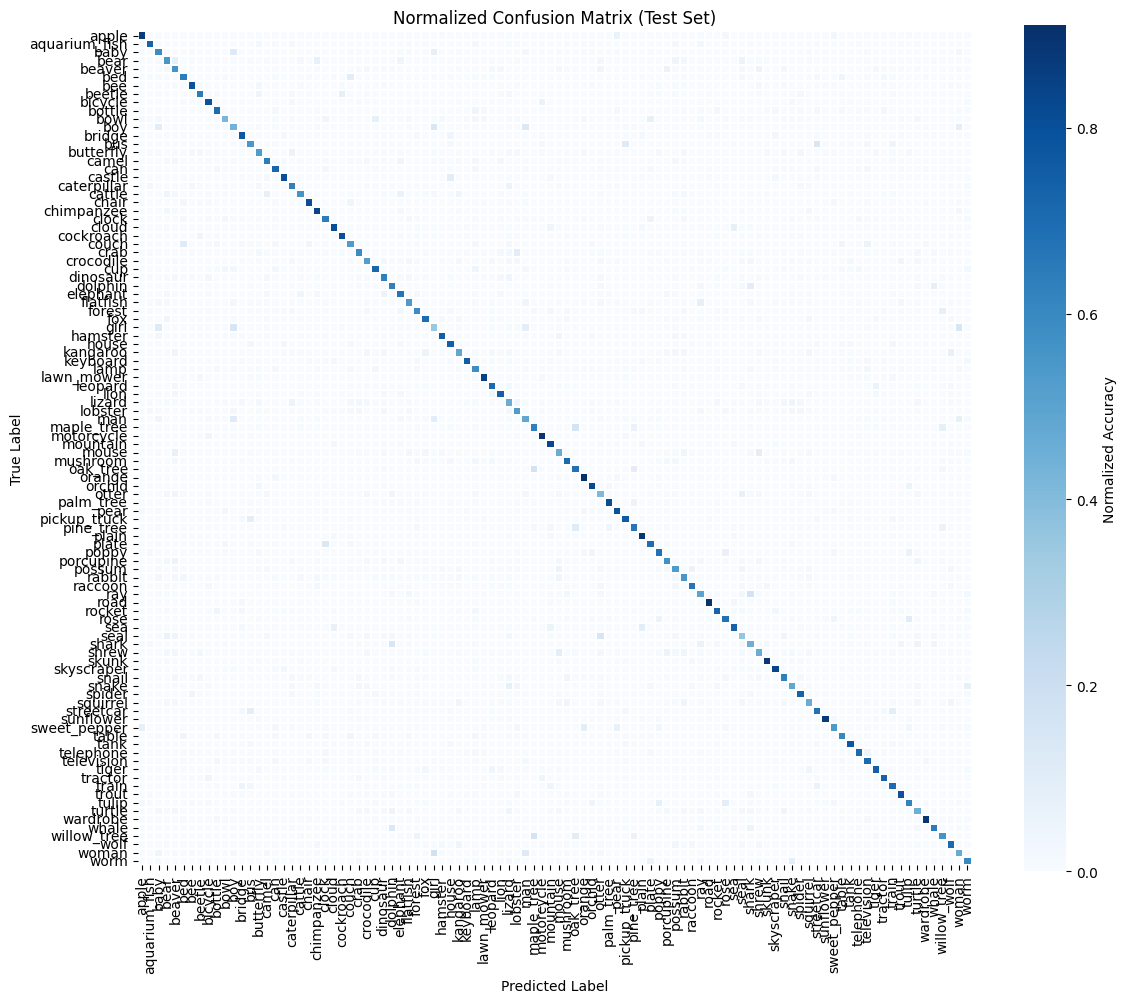

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix using true and predicted labels
cm = confusion_matrix(test_labels, test_preds)

# Normalize confusion matrix per true class (row-wise)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,10))
sns.heatmap(
    cm_norm,
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
    square=True,
    cbar_kws={"label": "Normalized Accuracy"},
    linewidths=0.1
)

plt.title("Normalized Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("plots/confusion_matrix_normalized.png", dpi=300)
plt.show()

# STEP 23: Per-Class Accuracy Analysis

In [ ]:
# Initialize counters for each CIFAR-100 class
class_correct = [0]*100
class_total = [0]*100

# Count correct predictions per class
for t,p in zip(test_labels, test_preds):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

# Compute accuracy for each class
class_acc = [class_correct[i]/class_total[i] if class_total[i] > 0 else 0 for i in range(100)]

# Save per-class accuracy to CSV for detailed analysis
import pandas as pd
df = pd.DataFrame({
    "Class": classes,
    "Accuracy": class_acc
})
df.to_csv("plots/per_class_accuracy.csv", index=False)

print("Saved per_class_accuracy.csv")

Saved per_class_accuracy.csv


# STEP 24: Identify and Visualize Worst Performing Classes

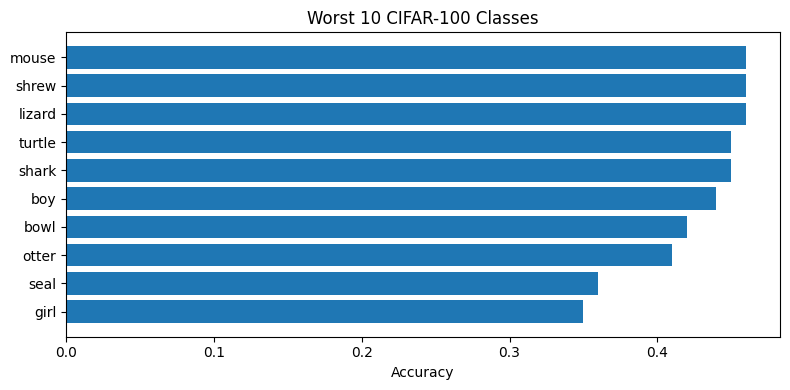

In [ ]:
# Sort classes by accuracy (ascending)
df_sorted = df.sort_values("Accuracy")

# Select 10 classes with lowest accuracy
worst = df_sorted.head(10)

# Plot horizontal bar chart of worst classes
plt.figure(figsize=(8,4))
plt.barh(worst["Class"], worst["Accuracy"])

plt.title("Worst 10 CIFAR-100 Classes")
plt.xlabel("Accuracy")
plt.tight_layout()

# Save plot for report
plt.savefig("plots/worst_classes.png", dpi=300)
plt.show()


# STEP 25: Model Complexity

In [ ]:
# Count total trainable parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters:", total_params)


Total Parameters: 11220132
